In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
data = pd.read_csv('Bengaluru_House_Data.csv')
#data.head()

In [ ]:
data.shape

(13320, 9)

In [ ]:
data.groupby('area_type').agg('count')

,availability,location,size,society,total_sqft,bath,balcony,price
area_type,,,,,,,,
Built-up Area,2418,2418,2418,1215,2418,2410,2310,2418
Carpet Area,87,87,87,54,87,87,82,87
Plot Area,2025,2025,2009,311,2025,2009,1837,2025
Super built-up Area,8790,8789,8790,6238,8790,8741,8482,8790


In [ ]:
#y = data['price']

In [ ]:
'''
x1 = sm.add_constant(data['bath'])
results = sm.OLS(y, x1).fit()
#results.summary()
'''

"\nx1 = sm.add_constant(data['bath'])\nresults = sm.OLS(y, x1).fit()\n#results.summary()\n"

In [ ]:
df = data.drop(['area_type', 'society', 'availability', 'balcony'], axis = 1)

In [ ]:
df = df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [ ]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

In [ ]:
df = df.drop('size', axis = 1)

In [ ]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [ ]:
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True


In [ ]:
df[~df['total_sqft'].apply(is_float)].head(10)

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


In [ ]:
def conversion(x):
  tokens = x.split('-')
  if len(tokens) == 2:
    return(float(tokens[0]) +float(tokens[1]))/2
  try:
    return float(x)
  except:
    return None

In [ ]:
df1 = df.copy()

In [ ]:
df1['total_sqft']=df1['total_sqft'].apply(conversion)

In [ ]:
df1.loc[30]

location      Yelahanka
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [ ]:
df2 = df1.copy()

In [ ]:
df2['price_per_sqft'] = df2['price']*100000/df1['total_sqft']

In [ ]:
len(df2['location'].unique())

1304

In [ ]:
df2.location = df2.location.apply(lambda x: x.strip())
location_stats = df2.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [ ]:
len(location_stats[location_stats <= 10])

1052

In [ ]:
location_less_than_10 = location_stats[location_stats <= 10]

In [ ]:
df2.location = df2.location.apply(lambda x: 'other' if x in location_less_than_10 else x)
len(df2.location.unique())

242

In [ ]:
df3 = df2[~(df2.total_sqft/df2.bhk < 300)]
df3

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5,6689.834926
13316,other,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4689.0,4.0,488.00,4,10407.336319


In [ ]:
df3.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [ ]:
def remove_outliers(df):
  df_out = pd.DataFrame()
  for key, subdf in df.groupby('location'):
    #print(key)
    #print(subdf)
    m = np.mean(subdf.price_per_sqft)
    st = np.std(subdf.price_per_sqft)
    reduced_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft <= (m+st))]
    df_out = pd.concat([df_out, reduced_df])
  return df_out
df4 = remove_outliers(df3)
df4.shape

(10241, 6)

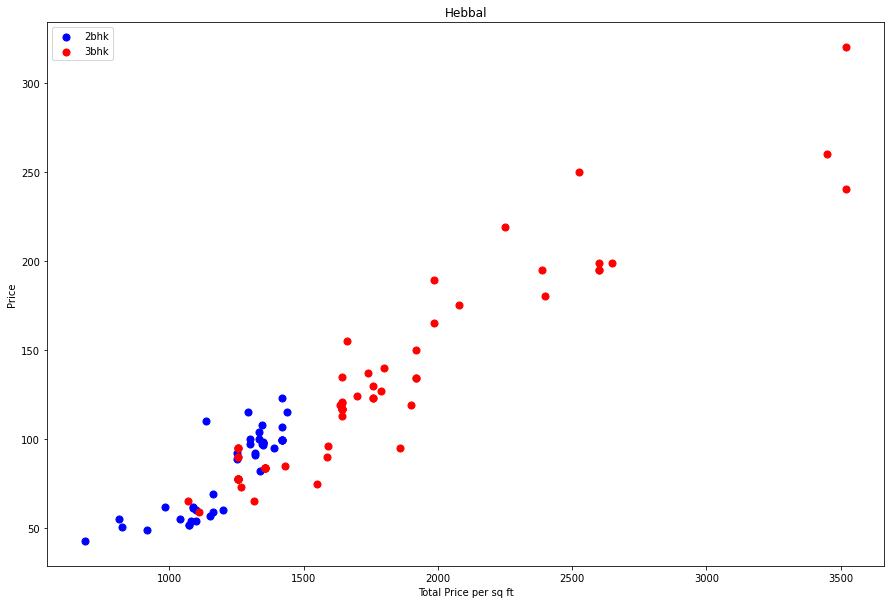

In [ ]:
def plot_scatter(df, location):
  bhk2 = df[(df.location == location) & (df.bhk==2)]
  bhk3 = df[(df.location == location) & (df.bhk==3)]
  plt.rcParams['figure.figsize'] = (15,10)
  plt.scatter(bhk2.total_sqft,bhk2.price, color = 'blue', label = '2bhk', s=50)
  plt.scatter(bhk3.total_sqft,bhk3.price, color = 'red', label = '3bhk', s=50)
  plt.xlabel("Total Price per sq ft")
  plt.ylabel("Price")
  plt.title(location)
  plt.legend()
  
plot_scatter(df4, 'Hebbal')

In [ ]:
def remove_bhk_outliers(df):
  exclude_indices = np.array([])
  for location, location_df in df.groupby('location'):
    bhk_stats = {}
    for bhk, bhk_df in location_df.groupby('bhk'):
      bhk_stats[bhk] = {
          'mean': np.mean(bhk_df.price_per_sqft),
          'std': np.std(bhk_df.price_per_sqft),
          'count': bhk_df.shape[0]  
        }
    for bhk, bhk_df in location_df.groupby('bhk'):
      stats = bhk_stats.get(bhk-1)
      if stats and stats['count'] > 5:
        exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
  return df.drop(exclude_indices, axis = 'index')
df5 = remove_bhk_outliers(df4)
df5.shape

(7329, 6)

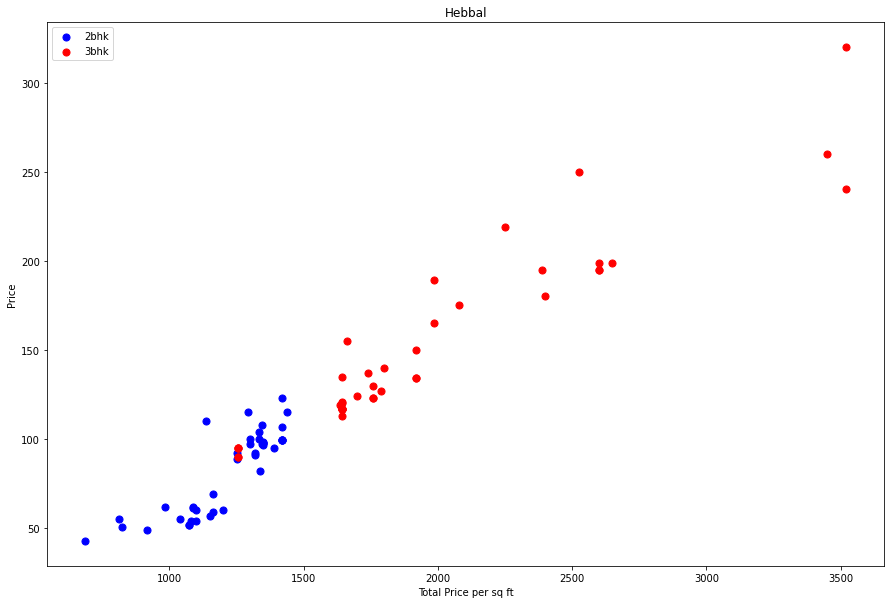

In [ ]:
plot_scatter(df5, 'Hebbal')

Text(0, 0.5, 'Count')

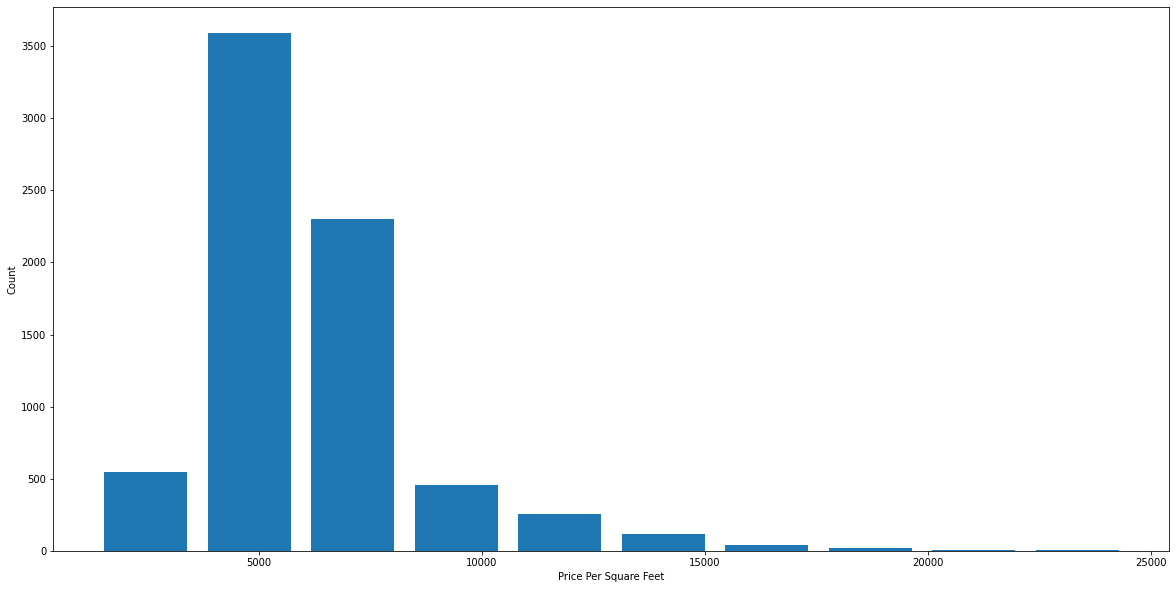

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df5.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

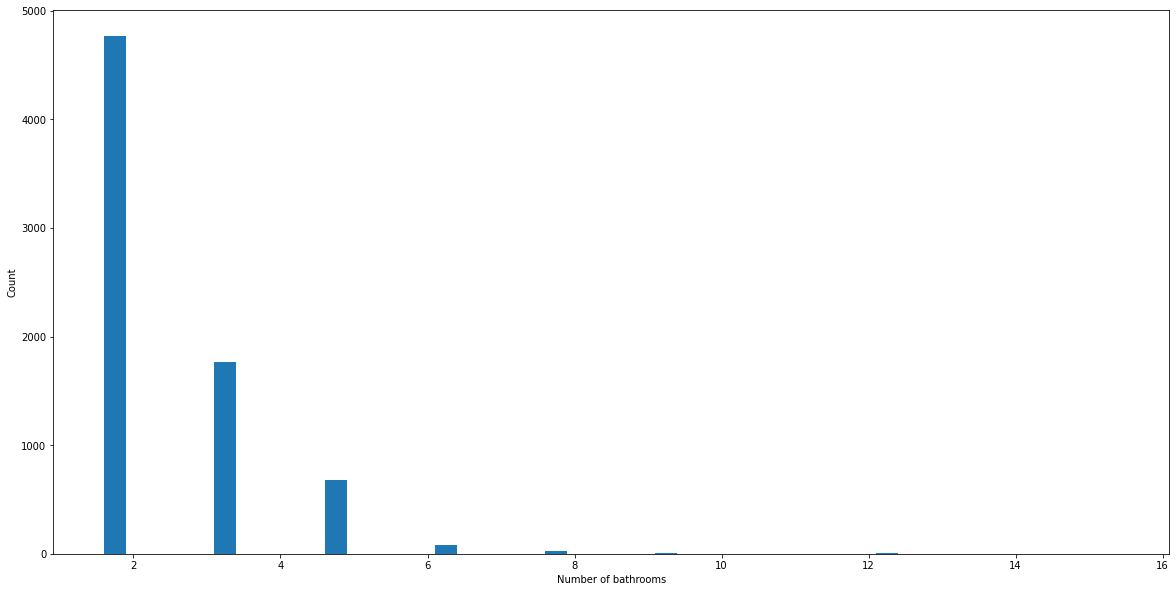

In [ ]:
plt.hist(df5.bath,rwidth=0.2)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [ ]:
df5[df5.bath>df5.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
7709,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
11366,Nagasandra,7000.0,8.0,450.0,4,6428.571429
12103,Thanisandra,1806.0,6.0,116.0,3,6423.034330
2620,other,11338.0,9.0,1000.0,6,8819.897689


In [ ]:
df6 = df5[df5.bath < df5.bhk+2]
df6 = df6.drop(['price_per_sqft'], axis = 1)
df6.shape

(7251, 5)

In [ ]:
dummies = pd.get_dummies(df6.location)

In [ ]:
df7 = pd.concat([df6, dummies.drop('other', axis = 1)], axis = 1)
df8 = df7.drop('location', axis = 1)
df8

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
210,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
848,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2152,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7138,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7358,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13238,1200.0,2.0,70.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13245,1800.0,1.0,200.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13285,1353.0,2.0,110.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13291,812.0,1.0,26.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x = df8.drop('price', axis = 1)
y = df8.price

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.8452277697874383

In [ ]:
y_hat = lr.predict(x_train)
y_hat

array([102.24604092, 234.68450509, 174.64648241, ...,  -5.2080464 ,
       447.6704634 ,  29.33984892])

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(),x, y, cv=cv)

array([0.82430186, 0.77166234, 0.85089567, 0.80837764, 0.83653286])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
def best_model(x, y):
  algos = {
      'linear_regression': {
          'model' : LinearRegression(),
          'params': {
              'normalize': [True, False]
          }
      },
      'lasso': {
          'model': Lasso(),
          'params': {
              'alpha': [1,2],
              'selection': ['random','cyclic']
          }
      }, 
      'decision_tree': {
          'model': DecisionTreeRegressor(),
          'params': {
              'criterion': ['mse', 'friedman_mse'],
              'splitter': ['best','random']
          }
      }
  }
  scores = []
  cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
  for algo_name, config in algos.items():
    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score = False)
    gs.fit(x, y)
    scores.append(
        {
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_

        })
  return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
best_model(x,y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pi

,model,best_score,best_params
0,linear_regression,0.818354,{'normalize': True}
1,lasso,0.687461,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.726179,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [ ]:
def predict_price(location, sqft, bath, bhk):
  loc_index = np.where(x.columns==location)[0][0]
  X = np.zeros(len(x.columns))
  X[0] = sqft
  X[1] = bath
  X[2] = bhk
  if loc_index >= 0:
    X[loc_index] = 1
  return lr.predict([X])[0]

In [ ]:
predict_price('1st Phase JP Nagar', 1000, 3, 3)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


86.80519395234735

In [ ]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr,f)

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))